# Calculate and index job aggregated values per site

   * scans all the panda jobs that had submitted_at earlier than the end of the period and transferred_at later than the start of the period
   * calculates number of active jobs in one minute intervals (DONE)
   * calculates IO rates in one minute intervals (to be done if needed)
   * store all these data in a new ES index (DONE)

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('font', **{'size': 12})

import requests
import pickle
import re
import datetime,time
from elasticsearch import Elasticsearch, helpers, exceptions as es_exceptions
from elasticsearch.helpers import scan
import datetime as dt

import numpy as np
import pandas as pd

es = Elasticsearch([{'host':'atlas-kibana.mwt2.org', 'port':9200}],timeout=60)

days_ago = 5

cdt = datetime.datetime.utcnow()
cdt = datetime.datetime(2017,10,10,12,0,0) # noon of the given date

usefull functions

In [2]:
def store(docs_to_store):
    try:
       res = helpers.bulk(es, docs_to_store, raise_on_exception=True,request_timeout=60)
       #print("inserted:",res[0], '\tErrors:',res[1])
    except es_exceptions.ConnectionError as e:
       print('ConnectionError ', e)
    except es_exceptions.TransportError as e:
       print('TransportError ', e)
    except helpers.BulkIndexError as e:
       print(e[0])
       for i in e[1]:
          print(i)
    except Exception as e:
       print('Something seriously wrong happened.',e)

#### Find indices to scan. We should scan at least 10 days before and 10 days after the day we are recalculating, so we cover all the very slow transfers.

In [3]:
indices = es.cat.indices(index="jobs_archive_*", h="index", request_timeout=600).split('\n')
indices = [x for x in indices if x != '']
indices = [x.strip() for x in indices]
#print(indices)

indices_to_scan=['jobs_archive_' + str(cdt.year) + '-' + str(cdt.month).zfill(2) + '-' + str(cdt.day).zfill(2)]

for d in range(1,days_ago+5):
    bef = cdt - dt.timedelta(days=d)
    ind_bef = 'jobs_archive_' + str(bef.year) + '-' + str(bef.month).zfill(2) + '-' + str(bef.day).zfill(2)
    if ind_bef in indices: indices_to_scan.append(ind_bef)
        
print(indices_to_scan)

['jobs_archive_2017-10-10', 'jobs_archive_2017-10-09', 'jobs_archive_2017-10-08', 'jobs_archive_2017-10-07', 'jobs_archive_2017-10-06', 'jobs_archive_2017-10-05', 'jobs_archive_2017-10-04', 'jobs_archive_2017-10-03', 'jobs_archive_2017-10-02', 'jobs_archive_2017-10-01']


#### Create structures to hold the data. Time bins are 1 minute.

In [4]:
stt=cdt- dt.timedelta(days=days_ago)
period_start = stt.replace(hour=0).replace(minute=0).replace(second=0)
period_end   = cdt.replace(hour=23).replace(minute=59).replace(second=59)

bot = dt.datetime(1970,1,1)
index_name='jobs-aggregates_' + str(period_start.year) + '-' + str(period_start.month)# + '-' + str(period_start.day)

ps = int((period_start - bot).total_seconds())
pe = int((period_end - bot).total_seconds())
print(period_start, period_end)

#caching periods
psb=int(ps/60)
pse=int(pe/60)
bins=[]
for t in range(psb,pse):
    bins.append(t*60)

endpoint_features = [ 'active_jobs'] # 'waiting_jobs', mcore_jobs, ingress, egress, ... 


    
class endpoint:
    def __init__(self, name):
        self.name=name
        self.df=pd.DataFrame(0, index = bins, columns = endpoint_features)
#         self.df['EndpointIgress'] = self.df['EndpointIgress'].astype('float64')
    def add_job(self, start_time, end_time):
        st=int(start_time/60)
        et=int(end_time/60)
        for ts in range(st,et+1):
            if ts>=psb and ts<pse: 
                timestamp = ts * 60
                val = self.df.get_value(timestamp, 'active_jobs') + 1
                self.df.set_value(timestamp, 'active_jobs', val)
#     def add_transfer(self, start_time, end_time, rate, direction):
#         st=int(start_time/60)
#         et=int(end_time/60)
#         area_covered = (et-st+1)*60 # area that will be covered in seconds
#         actual_seconds = end_time - start_time
#         scaled_rate = rate * actual_seconds / area_covered
#         if direction: 
#             drct='EndpointIgress'
#             drct1='IncomingTransfers'
#         else:
#             drct='EndpointEgress'
#             drct1='OutcomingTransfers'
#         for ts in range(st,et+1):
#             if ts>=psb and ts<pse: 
#                 timestamp = ts * 60
#                 val = self.df.get_value(timestamp, drct) + scaled_rate
#                 self.df.set_value(timestamp, drct, val)
#                 val = self.df.get_value(timestamp, drct1) + 1
#                 self.df.set_value(timestamp, drct1, val)
    def stats(self):
        print(self.df.describe())
    def plot_jobs(self):
        to_plot = self.df[['active_jobs']]
        to_plot.index = pd.to_datetime(to_plot.index, unit='s')
        to_plot.plot(style='-')
        plt.title(self.name)
        fig = plt.gcf()
        fig.set_size_inches(17, 8)
        plt.legend()
        plt.grid()
        plt.show()
        plt.savefig(self.name+'_active_jobs.png')
#     def plot_rates(self):
#         to_plot = self.df[['EndpointIgress','EndpointEgress']]
#         to_plot['EndpointEgress'] = to_plot['EndpointEgress'].mul(-1)
#         to_plot.index = pd.to_datetime(to_plot.index, unit='s')
#         to_plot.plot(style='-')
#         plt.title(self.name)
#         fig = plt.gcf()
#         fig.set_size_inches(17, 8)
#         plt.legend()
#         plt.grid()
#         plt.show()
#         plt.savefig(self.name+'_rate.png')
    def get_json_docs(self):
        docs=[]
        for index, row in self.df.iterrows():
            docs.append({ 
                '_index':index_name,
                '_type' : 'site',
                'timestamp' : int(index*1000),
                'name' : self.name,
                'jobs' : int(row['active_jobs'])
#                 'ingress' : float(row['EndpointIgress']),
#                 'egress' : float(row['EndpointEgress']),
#                 'incoming' : int(row['IncomingTransfers']),
#                 'outcoming' : int(row['OutcomingTransfers'])
                }
            )
        return docs

2017-10-05 00:00:00 2017-10-10 23:59:59


#### Load the data

In [5]:
query = {
    "size": 0,
    "_source": ["computingsite", "starttime","endtime"], #,"creationtime", "eventservice", "corecount"
    "query":{ 
        "bool" : {
            "must" : [
               # {"term" : { "computingsite" : "BNL_LOCAL" }},
               # {"term" : { "computingsite" : "CERN-PROD" }},
                {"exists" : { "field" : "eventservice" } },
                {"range" : {"endtime" : {  "gte": period_start } }},
                {"range" : {"starttime" :   {  "lt" : period_end } }}
                ]
        }
    }        
}

scroll = scan(client=es, index=indices_to_scan, query=query, scroll='5m', timeout="5m", size=10000)

endpoints={}

count = 0
for res in scroll:
    count += 1
    #if count>10: break
    if not count%100000 : print (count)
    r = res['_source']
    site = r['computingsite']
#     subm = (dt.datetime.strptime(r['creationtime'].strip('Z'), '%Y-%m-%dT%H:%M:%S') - bot).total_seconds()
    star = (dt.datetime.strptime(r['starttime'].strip('Z'), '%Y-%m-%dT%H:%M:%S') - bot).total_seconds()
    endt = (dt.datetime.strptime(r['endtime'].strip('Z'), '%Y-%m-%dT%H:%M:%S') - bot).total_seconds()
#     transfer_duration = tran - star
#     if transfer_duration > 0:
#         rate = float(r['bytes']) / transfer_duration * 0.000000953674316
    
    if site not in endpoints: endpoints[site]=endpoint(site)
    
    endpoints[site].add_job( star, endt)   
      
print(count)        
    #print(r['submitted_at'],r['started_at'],r['transferred_at'])


print( 'endpoints:',len(endpoints))



100000
200000
300000
400000
500000
600000
683321
endpoints: 46


In [6]:
print(endpoints.keys())

dict_keys(['UKI-NORTHGRID-MAN-HEP_SL6', 'AGLT2_LMEM', 'CONNECT_ES_ODYSSEY', 'ATLAS_OPP_OSG-GLOW', 'ATLAS_OPP_OSG_ES-UCONN', 'BOINC-ES', 'CONNECT_ES_JETSTREAM_MCORE', 'RAL-LCG2_ES', 'FZK-LCG2_MCORE', 'CERN-PROD_T0_SCORE_SHORT', 'UKI-SOUTHGRID-CAM-HEP_MCOREVAC', 'GRIF-LAL_HTCondor', 'CONNECT_ODYSSEY', 'AGLT2_SL6', 'UKI-NORTHGRID-LANCS-HEP_ES', 'BNL_LOCAL', 'CONNECT_ES_KARST_MCORE', 'UKI-NORTHGRID-MAN-HEP_MCORE', 'UKI-NORTHGRID-LANCS-HEP_SL7', 'LRZ-LMU_C2PAP_ES_MCORE', 'SWT2_CPB', 'BNL_PROD_MCORE', 'INFN-FRASCATI_MCORE', 'RAL-LCG2_SL6', 'UKI-NORTHGRID-SHEF-HEP_MCORE', 'MWT2_SL6', 'CERN-PROD_HI', 'FZK-LCG2', 'LRZ-LMU_MUC_MCORE1', 'OU_OSCER_ATLAS_OPP', 'UKI-LT2-QMUL_ES', 'OU_OSCER_ATLAS_TEST', 'CERN-PROD-preprod', 'INFN-ROMA1', 'RAL-LCG2_VAC', 'CERN-PROD', 'UKI-SOUTHGRID-SUSX_MCORE', 'ATLAS_OPP_OSG_ES-PURDUE', 'RAL-LCG2-ECHO_MCORE', 'UKI-SOUTHGRID-CAM-HEP_MCORE', 'RAL-LCG2_HIMEM_SL6', 'INFN-COSENZA-RECAS', 'UKI-LT2-QMUL_HIMEM_SL6', 'SLAC_ES', 'OU_OSCER_ATLAS', 'UKI-LT2-RHUL_MCORE'])


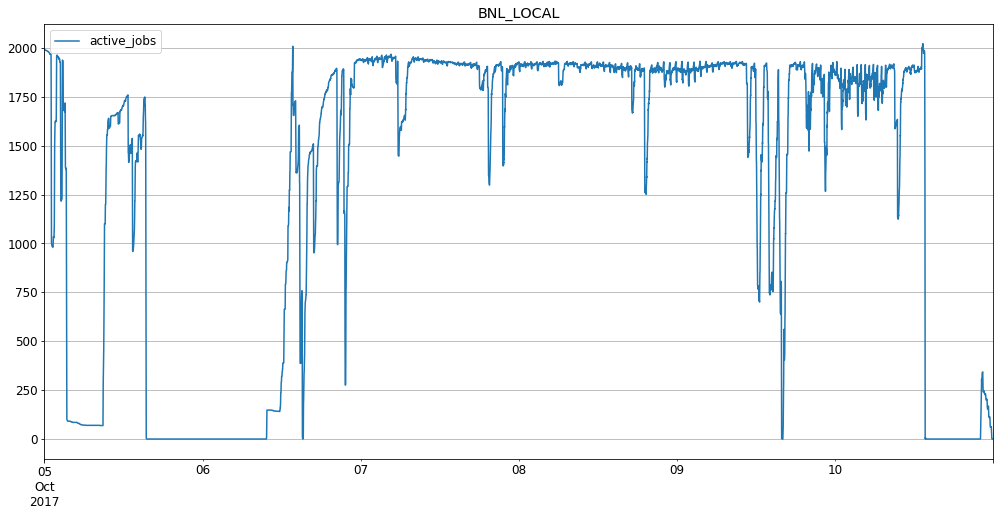

In [7]:
endpoints['BNL_LOCAL'].plot_jobs()

In [8]:
endpoints['BNL_LOCAL'].df['active_jobs']

1507161600    1990
1507161660    1990
1507161720    1990
1507161780    1990
1507161840    1990
1507161900    1990
1507161960    1988
1507162020    1988
1507162080    1988
1507162140    1988
1507162200    1988
1507162260    1988
1507162320    1988
1507162380    1988
1507162440    1987
1507162500    1985
1507162560    1985
1507162620    1985
1507162680    1985
1507162740    1985
1507162800    1985
1507162860    1985
1507162920    1985
1507162980    1985
1507163040    1984
1507163100    1984
1507163160    1984
1507163220    1984
1507163280    1983
1507163340    1983
              ... 
1507678140     113
1507678200     103
1507678260      76
1507678320      68
1507678380      64
1507678440      61
1507678500      61
1507678560      61
1507678620      61
1507678680      62
1507678740      62
1507678800      62
1507678860      62
1507678920      63
1507678980      48
1507679040      21
1507679100      14
1507679160       5
1507679220       2
1507679280       0
1507679340       0
1507679400  

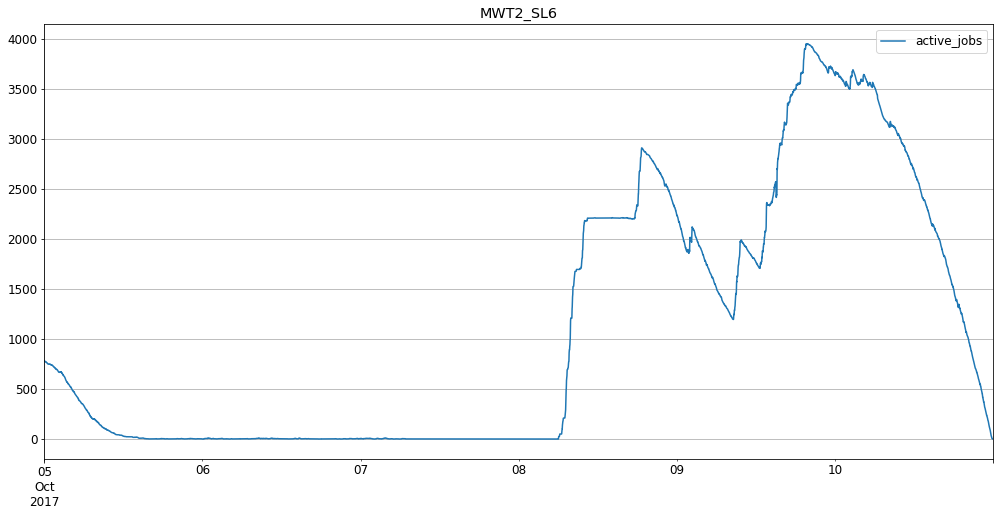

In [9]:
endpoints['MWT2_SL6'].plot_jobs()

In [10]:
endpoints['MWT2_SL6'].stats()

       active_jobs
count  8639.000000
mean   1104.439055
std    1311.743007
min       0.000000
25%       2.000000
50%     200.000000
75%    2210.000000
max    3956.000000


#### storing data into ES

In [13]:
for endpoint in endpoints.values():
    print('endpoint indexed: ', endpoint.name)
    #print(endpoint.get_json_docs())
    store(endpoint.get_json_docs())
    #break

endpoint indexed:  UKI-NORTHGRID-MAN-HEP_SL6
endpoint indexed:  AGLT2_LMEM
endpoint indexed:  CONNECT_ES_ODYSSEY
endpoint indexed:  ATLAS_OPP_OSG-GLOW
endpoint indexed:  ATLAS_OPP_OSG_ES-UCONN
endpoint indexed:  BOINC-ES
endpoint indexed:  CONNECT_ES_JETSTREAM_MCORE
endpoint indexed:  RAL-LCG2_ES
endpoint indexed:  FZK-LCG2_MCORE
endpoint indexed:  CERN-PROD_T0_SCORE_SHORT
endpoint indexed:  UKI-SOUTHGRID-CAM-HEP_MCOREVAC
endpoint indexed:  GRIF-LAL_HTCondor
endpoint indexed:  CONNECT_ODYSSEY
endpoint indexed:  AGLT2_SL6
endpoint indexed:  UKI-NORTHGRID-LANCS-HEP_ES
endpoint indexed:  BNL_LOCAL
endpoint indexed:  CONNECT_ES_KARST_MCORE
endpoint indexed:  UKI-NORTHGRID-MAN-HEP_MCORE
endpoint indexed:  UKI-NORTHGRID-LANCS-HEP_SL7
endpoint indexed:  LRZ-LMU_C2PAP_ES_MCORE
endpoint indexed:  SWT2_CPB
endpoint indexed:  BNL_PROD_MCORE
endpoint indexed:  INFN-FRASCATI_MCORE
endpoint indexed:  RAL-LCG2_SL6
endpoint indexed:  UKI-NORTHGRID-SHEF-HEP_MCORE
endpoint indexed:  MWT2_SL6
endpoint in

In [12]:
print('done')

done
